In [ ]:
import os

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/data/test.csv")

# 1. date 변수 변환


In [ ]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#date 컬럼을 판다스의 datetime 변수형으로 변환한다.
train["date"] = pd.to_datetime(train['date'])

In [ ]:
#date 컬럼으로부터 요일을 뽑아낸다.
train['weekday'] = train['date'].dt.weekday

In [ ]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


In [ ]:
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday

In [ ]:
train.groupby(by="weekday")["18~20_ride"].sum()

weekday
0    104073.0
1     87220.0
2     88404.0
3     74122.0
4     59451.0
5     48419.0
6     54306.0
Name: 18~20_ride, dtype: float64

# 2. in_out 변수 변환


In [ ]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [ ]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

# 3. 변수간 상관관계 확인

In [ ]:
cor=train.corr()

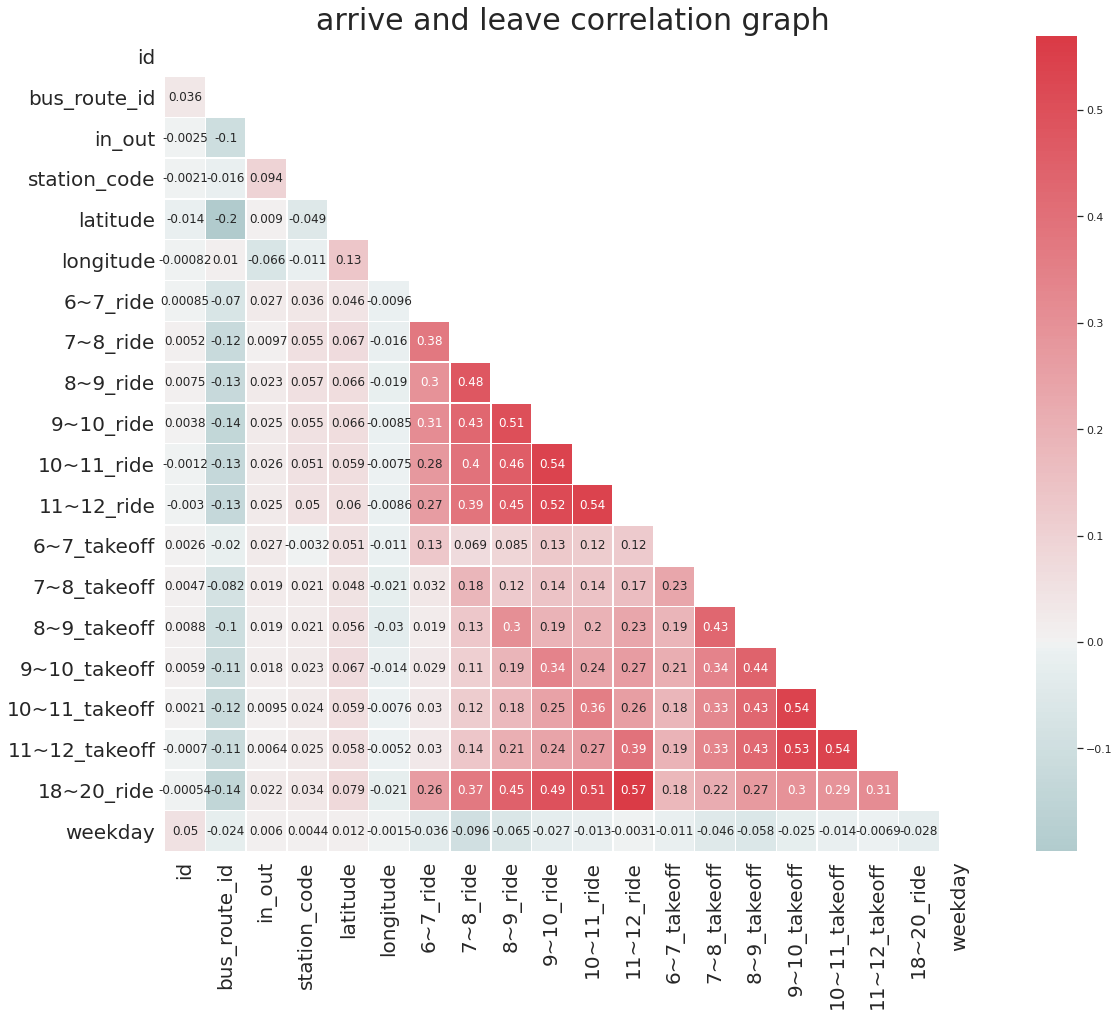

In [190]:
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [ ]:
del train['station_name']
del test['station_name']

# 4. 좌표 데이터를 이용한 Feature Engineering
## 4-1. 측정소 위치 및 정류장 위치 확인

In [ ]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

## 4-2. 측정소와 정류장 사이 거리 계산 적용


In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

In [ ]:
train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [ ]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )

In [ ]:
total.head()

,jeju,gosan,seongsan,po
0,4.286659,37.692766,37.713630,27.841879
1,4.966848,37.008492,38.465822,27.996179
2,6.330746,35.642126,39.259820,27.496551
3,3.575272,38.643401,38.386802,29.579404
4,30.652098,23.648361,45.899140,14.269792


In [ ]:
train['dist_name'] = total.apply(lambda x: x.argmin(),axis=1)

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(),axis=1)

# 5. 외부 실제 측정 데이터 활용


In [ ]:
# https://data.kma.go.kr/cmmn/main.do
#데이터 불러오기
raining=pd.read_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/data/OBS_ASOS_TIM_20210114113345.csv",engine='python',encoding="cp949")

In [ ]:
raining.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,184,제주,2019-09-01 01:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
1,184,제주,2019-09-01 02:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
2,184,제주,2019-09-01 03:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
3,184,제주,2019-09-01 04:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN
4,184,제주,2019-09-01 05:00,23.3,NaN,1.2,180.0,71,1013.6,1016.0,NaN,NaN


In [ ]:
#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['0' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['1' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['2' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['3' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

In [ ]:
raining.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,0,제주,2019-09-01 01:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
1,0,제주,2019-09-01 02:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
2,0,제주,2019-09-01 03:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
3,0,제주,2019-09-01 04:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN
4,0,제주,2019-09-01 05:00,23.3,NaN,1.2,180.0,71,1013.6,1016.0,NaN,NaN


In [ ]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 
raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

In [ ]:
# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>12)  ]

In [ ]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)',"습도(%)","풍속(m/s)"]].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

In [ ]:
rain3.head()

,지점,일시,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,0,2019-09-01,22.727273,2.272727,89.363636,2.318182
1,0,2019-09-02,25.245455,NaN,89.909091,1.545455
2,0,2019-09-03,25.109091,0.200000,93.909091,3.009091
3,0,2019-09-04,25.145455,1.675000,88.363636,1.372727
4,0,2019-09-05,26.472727,0.766667,91.818182,2.009091


In [ ]:
# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(method="bfill")

In [ ]:
rain3.head()

,dist_name,date,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,0,2019-09-01,22.727273,2.272727,89.363636,2.318182
1,0,2019-09-02,25.245455,0.200000,89.909091,1.545455
2,0,2019-09-03,25.109091,0.200000,93.909091,3.009091
3,0,2019-09-04,25.145455,1.675000,88.363636,1.372727
4,0,2019-09-05,26.472727,0.766667,91.818182,2.009091


In [ ]:
rain3["dist_name"] = rain3["dist_name"].apply(lambda x: int(x))
rain3["date"] = pd.to_datetime(rain3["date"])

In [ ]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

In [ ]:
test2.head()

,id,date,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,415423,2019-10-01,4270000,1,344,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,4.286659,37.692766,37.713630,27.841879,0,23.009091,2.245455,91.727273,3.181818
1,415424,2019-10-01,4270000,1,357,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4.966848,37.008492,38.465822,27.996179,0,23.009091,2.245455,91.727273,3.181818
2,415425,2019-10-01,4270000,1,432,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6.330746,35.642126,39.259820,27.496551,0,23.009091,2.245455,91.727273,3.181818
3,415426,2019-10-01,4270000,0,1579,33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.575272,38.643401,38.386802,29.579404,0,23.009091,2.245455,91.727273,3.181818
4,415427,2019-10-01,4270000,0,1636,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,31.460686,23.594010,46.355301,14.445605,3,22.518182,2.700000,99.000000,3.709091


In [ ]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

train2 = pd.get_dummies(train2,columns=['weekday'])
test2 = pd.get_dummies(test2,columns=['weekday'])

In [ ]:
train2.shape, test2.shape, train.shape, test.shape
((415423, 44), (228170, 43), (415423, 39), (228170, 38))

((415423, 44), (228170, 43), (415423, 39), (228170, 38))

# 6. randomforest을 활용한 모델링
## 6-1. 변수 선택 및 train data sampling


In [ ]:
train2 = train2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})
test2 = test2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})

In [ ]:
train2

,id,date,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),습도(%),풍속(m/s),dist_name_jeju,dist_name_gosan,dist_name_seongsan,dist_name_po,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,2019-09-01,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
1,1,2019-09-01,4270000,1,357,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.966848,37.008492,38.465822,27.996179,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
2,2,2019-09-01,4270000,1,432,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.330746,35.642126,39.259820,27.496551,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
3,3,2019-09-01,4270000,0,1579,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,3.575272,38.643401,38.386802,29.579404,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
4,4,2019-09-01,4270000,0,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.652098,23.648361,45.899140,14.269792,22.127273,1.627273,98.454545,2.109091,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.117280,16.319339,57.465292,33.738981,23.972727,5.514286,94.090909,2.754545,0,1,0,0,1,0,0,0,0,0,0
415419,415419,2019-09-30,32820000,0,1564,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.134693,39.904297,36.202951,28.484278,23.918182,4.520000,92.454545,1.345455,1,0,0,0,1,0,0,0,0,0,0
415420,415420,2019-09-30,32820000,0,2322,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40.039090,11.626985,60.041783,28.249863,23.972727,5.514286,94.090909,2.754545,0,1,0,0,1,0,0,0,0,0,0
415421,415421,2019-09-30,32820000,0,3291,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.355649,23.876917,52.933244,33.392008,23.918182,4.520000,92.454545,1.345455,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
train2.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'latitude',
       'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po', '기온(°C)', '강수량(mm)',
       '습도(%)', '풍속(m/s)', 'dist_name_jeju', 'dist_name_gosan',
       'dist_name_seongsan', 'dist_name_po', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [ ]:
X_train=train2.drop(columns=["id","date","18~20_ride","bus_route_id","station_code"])
y_train = train2["18~20_ride"]

In [ ]:
X_test=test2.drop(columns=["id","date","bus_route_id","station_code"])

In [ ]:
X_train.shape, y_train.shape

((415423, 34), (415423,))

In [ ]:
X_test.shape

(228170, 34)

## 6-2. Neural Networks

In [ ]:
X_train.head()

,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),습도(%),풍속(m/s),dist_name_jeju,dist_name_gosan,dist_name_seongsan,dist_name_po,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
1,1,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
2,1,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
3,0,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,22.727273,2.272727,89.363636,2.318182,1,0,0,0,0,0,0,0,0,0,1
4,0,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.652098,23.648361,45.899140,14.269792,22.127273,1.627273,98.454545,2.109091,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
y_train.head()

0     0.0
1     5.0
2     2.0
3    53.0
4     0.0
Name: 18~20_ride, dtype: float64

In [204]:
for i in X_train.columns:
  X_train[i] = X_train[i].apply(lambda x: float(x))

In [246]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation

In [395]:
model = Sequential()

model.add(Dense(128,input_dim=34))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1))

In [396]:
model.compile(loss="mse",optimizer='adamax',metrics="acc")

In [397]:
hist = model.fit(X_train, y_train, epochs=5,batch_size=32)

Epoch 1/5
12982/12982 [==============================] - 16s 1ms/step - loss: 15.3785 - acc: 0.4337
Epoch 2/5
12982/12982 [==============================] - 16s 1ms/step - loss: 13.4988 - acc: 0.4585
Epoch 3/5
12982/12982 [==============================] - 16s 1ms/step - loss: 12.4096 - acc: 0.4645
Epoch 4/5
12982/12982 [==============================] - 16s 1ms/step - loss: 12.0807 - acc: 0.4595
Epoch 5/5
12982/12982 [==============================] - 16s 1ms/step - loss: 12.5659 - acc: 0.4670


In [398]:
test['18~20_ride'] = model.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

In [399]:
test[['id','18~20_ride']].to_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/1. 버스 승차량 예측 프로젝트/DL/submission/submission_0115(2).csv",index=False)